# <font color=#fe645d>Spam Filter</font> with Naive Bayes

This notebook contains my own explanations and comments on an exercise from an Udemy Course on Machine Learning. I hope this can be useful for those who are just starting with this topic.

#### About the dataset:
The dataset I used is local to my computer, downloaded from the <mark>Spam Assasin</mark> website. You may want to use the JSON file provided in <mark>Kaggle:</mark> https://www.kaggle.com/code/gin/data.</mark> If you choose the last option, you can skip the first sections about reading and extracting the e-mails.


## Notebook Imports 📓

In [261]:
from os import walk
from os.path import join
import pandas as pd
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from PIL import Image # helps us edit images

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

## Reading Files 📖

In [176]:
# we can check the encoding of the our system

import sys
sys.getfilesystemencoding()

# It is 'utf-8', which is diferent than the encoding we are going to use for the files


'utf-8'

In [284]:
# constant file paths:
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'
# constant categories HAM vs SPAM:
SPAM_CAT = 1
HAM_CAT = 0

VOCAB_SIZE = 2500

# the dataframe file we're going to create later in the notebook
DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data-mine.json'
SKULL = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'


# created files:
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'
DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data-mine.json'
TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

### Generator function example 👩‍💻

We can extract all the e-mail bodies from the file with a function, but we have to be careful as we're reading from a lot of files, so we can use a generator function instead.

In [178]:
# Creating a generator object
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [179]:
# calling this function will not be very usefull on its own
# see how it just returns the generator object
generate_squares(6)

<generator object generate_squares at 0x7fd8dfcc3f90>

In [180]:
#However, we can use the generator function to help us do other interesting things

for i in generate_squares(5):
    print(i, end= ' ->')
    
# We can of course do this by just creating a simple square function
# But the generator function remembers where we left the last result
# The yield keyword let us exit the function but remember where we left it
# When we have a large data set, it will take a lot of work and time for 
# it to be computed, even if we just use one single value



0 ->1 ->4 ->9 ->16 ->

## E-mail body extraction 📝

In [181]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')
            is_body = False
            lines = []
            
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
                    
            stream.close()
            email_body = '\n'.join(lines)
            
            yield file_name, email_body
            

## Setting the the spam files into a DataFrame ✔️

In [182]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index = row_names)
    
    

In [183]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [184]:
#spam_emails.shape
spam_emails.CATEGORY.value_counts()

1    1898
Name: CATEGORY, dtype: int64

## Setting the non-spam files into a DataFrame ✔️

In [185]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

## A DataFrame that holds ALL e-mails ✔️

In [186]:
data = pd.concat((ham_emails, spam_emails))
data.CATEGORY.value_counts()

0    3901
1    1898
Name: CATEGORY, dtype: int64

In [187]:
data.shape

(5799, 2)

In [193]:
data.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


# Cleaning the data 🧹
We need to check for empty e-mails, missing values, or null values

In [194]:
print("Are there None values in the data: ", data['MESSAGE'].isnull().values.any()) # here we can check if there are any null values
# It returns False for this dataset
# However, a null value is not the same as an empty e-mail
# We need to find strings of length 0 in our messages



Are there None values in the data:  False


In [195]:
print("Are there empty e-mails in the data: ", (data.MESSAGE.str.len() == 0).any())
# It returns True for this dataset : we have empty videos.



Are there empty e-mails in the data:  True


In [196]:
print("Strings with length 0: ", (data.MESSAGE.str.len() == 0).sum())

Strings with length 0:  3


### Locate the empty e-mails ✔️

In [197]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

These files do not seem to be an e-mail, as they don't have the same type of name as all the others... they are system files. We stil may need to discard them anyways.

In [198]:
data.drop(['cmds'], inplace = True) #delete the empty e-mails

In [199]:
(data.MESSAGE.str.len() == 0).any() # Now we can check if this worked

False

In [200]:
data.shape

(5796, 2)

### Add Document IDs to Track Emails in Dataset ✔️

In [201]:
document_ids = range(0, len(data.index))

In [202]:
data['DOC_ID'] = document_ids

In [203]:
data.DOC_ID

00001.7c53336b37003a9286aba55d2945844c       0
00002.9c4069e25e1ef370c078db7ee85ff9ac       1
00003.860e3c3cee1b42ead714c5c874fe25f7       2
00004.864220c5b6930b209cc287c361c99af1       3
00005.bf27cdeaf0b8c4647ecd61b1d09da613       4
                                          ... 
01396.e80a10644810bc2ae3c1b58c5fd38dfa    5791
01397.f75f0dd0dd923faefa3e9cc5ecb8c906    5792
01398.8ca7045aae4184d56e8509dc5ad6d979    5793
01399.2319643317e2c5193d574e40a71809c2    5794
01400.b444b69845db2fa0a4693ca04e6ac5c5    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [204]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace = True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0,00001.7c53336b37003a9286aba55d2945844c
1,"Martin A posted:\n\nTassos Papadopoulos, the G...",0,00002.9c4069e25e1ef370c078db7ee85ff9ac
2,Man Threatens Explosion In Moscow \n\n\n\nThur...,0,00003.860e3c3cee1b42ead714c5c874fe25f7
3,Klez: The Virus That Won't Die\n\n \n\nAlready...,0,00004.864220c5b6930b209cc287c361c99af1
4,"> in adding cream to spaghetti carbonara, whi...",0,00005.bf27cdeaf0b8c4647ecd61b1d09da613


In [205]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",1,01396.e80a10644810bc2ae3c1b58c5fd38dfa
5792,This is a multi-part message in MIME format.\n...,1,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
5793,"Dear Subscriber,\n\n\n\nIf I could show you a ...",1,01398.8ca7045aae4184d56e8509dc5ad6d979
5794,****Mid-Summer Customer Appreciation SALE!****...,1,01399.2319643317e2c5193d574e40a71809c2
5795,ATTN:SIR/MADAN \n\n\n\n ...,1,01400.b444b69845db2fa0a4693ca04e6ac5c5


## Saving DataFrame to File using Pandas 🐼

We may want to use this data frame again in another notebook. A way of doing this is with JSON files. 

In [206]:
data.to_json(DATA_JSON_FILE)

## Data <font color=#5d7ffe>Visualization</font> for these DataSets

In [207]:
data.CATEGORY.value_counts() # Will give us the counts for each category

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [208]:
amount_of_spam = data.CATEGORY.value_counts()[SPAM_CAT]
amount_of_ham = data.CATEGORY.value_counts()[HAM_CAT]

### Pie chart 🥧

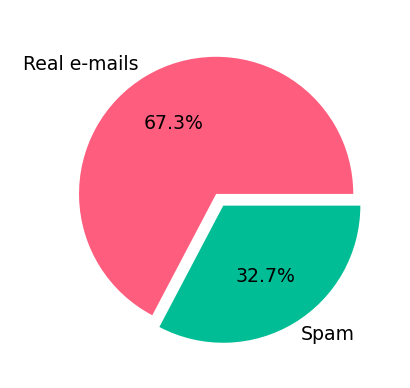

In [209]:
category_names = [ 'Real e-mails', 'Spam']
custom_colors = ['#fe5d7e', '#01bd96']
sizes = [amount_of_ham, amount_of_spam]
plt.figure(figsize = (2,2), dpi = 227) #dpi = 227 helps us with screen resolution
plt.pie(sizes, labels = category_names, textprops={'fontsize': 6},
        autopct='%1.1f%%', colors = custom_colors, explode = [0, 0.1])
# autopct='%1.1f%%' will show the percentages with one decimal point 
# explode = [0, 0.1] will separate the pieces of the chart
plt.show()

# Text Preprosessing

* Download the NLTK Resources (Tokenizer and Stopwords)

### Tokenize ✔️
A _tokenizer_ is a function used in Natural Language Processing that splits up the words in a sentence into individual words.



In [210]:
nltk.download('punkt') #a tokenizer

[nltk_data] Downloading package punkt to /home/vanepet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [211]:
# testing the tokenizers
msg = "Street's like a jungle, so call the police"
words = word_tokenize(msg.lower())
print(words)

['street', "'s", 'like', 'a', 'jungle', ',', 'so', 'call', 'the', 'police']


### Removing stopwords ✔️
Words like "and," "be" may not be very usefull for an analysis as they are present everywhere and do not convey meaningful information

In [83]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vanepet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [212]:
stop_words = set(stopwords.words('english'))

words = word_tokenize(msg.lower())

filtered_words = []
# Challenge: append non-stop words to filtered_words
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print("The filtered words are ", filtered_words)

The filtered words are  ['street', "'s", 'like', 'jungle', ',', 'call', 'police']


<mark>NOTE:</mark> We still have punctuation, and the shrinked form of the stopword "is", "s", is still a part of the tokens here. These shouldn't be tokens in a more serious NLP task, as they do not carry relevant meaning. You can check that "is" is considered a stepword in English:

In [85]:
if 'is' in stop_words: print('Found it!')

Found it!


### Stemming ✔️

We need a way of considering tokens like "fishing", and "fished" the same word. For this, we're going to use an algorithm called the <mark>**Porter stemmer**</mark>, developed by Martin Porter, which is the de facto stemmer for the English language.

There are other stemmers to choose. A popular one is the <mark>**Snowball stemmer**</mark>, which lets us choose the language.

In [213]:
stemmer = PorterStemmer()
msg = "Street's like a jungle, so call the police. Nobody expects the Spanish Inquisition!"
words = word_tokenize(msg.lower())
filtered_words = []

for word in words:
    # isalpha() will check if a character is a letter
    # it will help us remove punctuation marks
    if word not in stop_words and word.isalpha(): 
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['street', 'like', 'jungl', 'call', 'polic', 'nobodi', 'expect', 'spanish', 'inquisit']


### Removing HTML tags from the e-mails ✔️
E-mails usually contain some formatting in HTML, which we need to remove in order to process the texts correctly. We can do this by using an import called <mark>BeautifulSoup</mark>. 

You can see the HTML tags with the code below this cell:

In [87]:
data.at[2, 'MESSAGE']

"Man Threatens Explosion In Moscow \n\n\n\nThursday August 22, 2002 1:40 PM\n\nMOSCOW (AP) - Security officers on Thursday seized an unidentified man who\n\nsaid he was armed with explosives and threatened to blow up his truck in\n\nfront of Russia's Federal Security Services headquarters in Moscow, NTV\n\ntelevision reported.\n\nThe officers seized an automatic rifle the man was carrying, then the man\n\ngot out of the truck and was taken into custody, NTV said. No other details\n\nwere immediately available.\n\nThe man had demanded talks with high government officials, the Interfax and\n\nITAR-Tass news agencies said. Ekho Moskvy radio reported that he wanted to\n\ntalk with Russian President Vladimir Putin.\n\nPolice and security forces rushed to the Security Service building, within\n\nblocks of the Kremlin, Red Square and the Bolshoi Ballet, and surrounded the\n\nman, who claimed to have one and a half tons of explosives, the news\n\nagencies said. Negotiations continued for about

In the following cell you'll see how BeautifulSoup changes that formatting:

In [214]:
soup = BeautifulSoup(data.at[4, 'MESSAGE'], 'html.parser')  
# notice that 'html.parser' is included in python. 
print(soup.prettify()) 
# prettify makes the text nicer to read.

&gt;  in adding cream to spaghetti carbonara, which has the same effect on pasta as

&gt;  making a pizza a deep-pie; 



I just had to jump in here as Carbonara is one of my favourites to make and ask 

what the hell are you supposed to use instead of cream?  I've never seen a 

recipe that hasn't used this.  Personally I use low fat creme fraiche because it 

works quite nicely but the only time I've seen an supposedly authentic recipe 

for carbonara  it was identical to mine (cream, eggs and lots of fresh parmesan) 

except for the creme fraiche.



Stew

-- 

Stewart Smith

Scottish Microelectronics Centre, University of Edinburgh.

http://www.ee.ed.ac.uk/~sxs/





------------------------ Yahoo! Groups Sponsor ---------------------~--&gt;

4 DVDs Free +s&amp;p Join Now

http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM

---------------------------------------------------------------------~-&gt;



To unsubscribe from this group, send an email to:

forteana-unsubscribe@egr

## ❗Tokenizing and Stemming: Combined Function 
Here we're going to sum up all the previous steps in a function we can use repeatedly :D

In [215]:
def clean_message(message, stemmer = PorterStemmer(), 
                 stop_words = set(stopwords.words('english'))):
    
    # remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    words = word_tokenize(cleaned_text.lower()) #Tokenize
    
    filtered_words = []
    
    for word in words:
        # Remove stepwords and punctuation
        if word not in stop_words and word.isalpha(): 
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words
        

In [216]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)


# Example in use:
# clean_message(data.at[2, "MESSAGE"])

## Slicing DataFrames, Creating Subsets and Counting Data

In [107]:
# We apply the function with the help of a mapping function

nested_list_of_sentences = data.MESSAGE.apply(clean_message)

/home/vanepet/users/vanep/envs/in2110/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/home/vanepet/users/vanep/envs/in2110/lib/python3.9/site-packages/bs4/__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [217]:
nested_list_of_sentences.head()

DOC_ID
0    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1    [martin, post, tasso, papadopoulo, greek, scul...
2    [man, threaten, explos, moscow, thursday, augu...
3    [klez, viru, wo, die, alreadi, prolif, viru, e...
4    [ad, cream, spaghetti, carbonara, effect, past...
Name: MESSAGE, dtype: object

In [218]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [269]:
# We create two nested lists, one with ham, one with spam, with the help of the doc_ids

nested_list_spam = nested_list_of_sentences.loc[doc_ids_spam]
nested_list_ham = nested_list_of_sentences.loc[doc_ids_ham]

In [227]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]


In [228]:
normal_words= pd.Series(flat_list_ham).value_counts() # will give us the unique words

print("Number of unique words in normal e-mails: ", normal_words.shape[0]) #unique words
print( "10 most common words in normal e-mails:\n", normal_words[:10]) # 10 most common words



Number of unique words in normal e-mails:  20815
10 most common words in normal e-mails:
 http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64


In [224]:
flat_list_spam = [ item for sublist in nested_list_spam for item in sublist]

spam_words= pd.Series(flat_list_spam).value_counts() # will give us the unique words

print("Number of unique words in spam e-mails: ", spam_words.shape[0]) #unique words
print( "10 most common words in spam e-mails:\n", spam_words[:10])

Number of unique words in spam e-mails:  13242
10 most common words in spam e-mails:
 http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64


## Word Cloud  <font color=#5d7ffe>Visualization</font>☁️

### Non-Spam E-mails Word Cloud

In [230]:
#Preprosessing of Word Cloud data

ham_as_string = ' '.join(flat_list_ham)

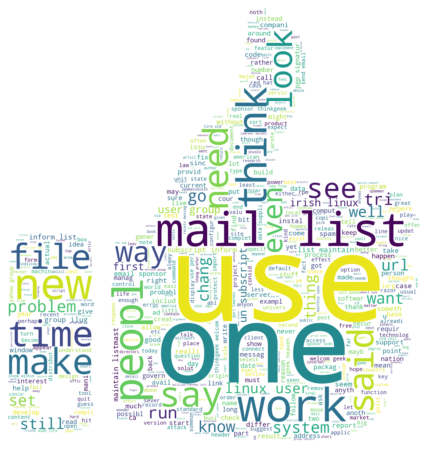

In [237]:
icon = Image.open(THUMBS_UP)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=600, colormap='viridis')

word_cloud.generate(ham_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Spam e-mails Word Cloud ☁️

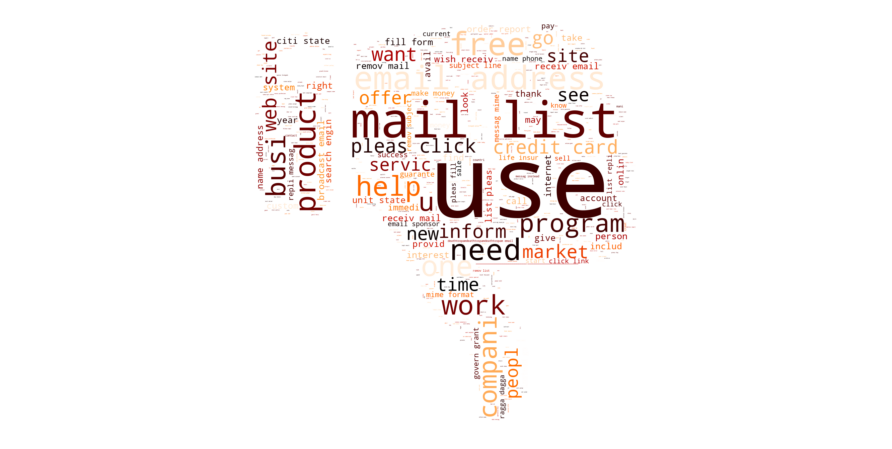

In [241]:
icon = Image.open(THUMBS_DOWN)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_as_string = ' '.join(flat_list_spam)

word_cloud_down = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                      max_words=600, colormap='gist_heat')

word_cloud_down.generate(spam_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud_down, interpolation='bilinear')
plt.axis('off')
plt.show()

# Dictionary and Vocabulary 📚

We need a dictionary and a vocabulary of the words in the whole corpus we're using

### 1) Dictionary

In [245]:
stemmed_nested_list = data.MESSAGE.apply(clean_message)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

### Most frequent words 🔢

In [248]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most frequent words: \n', frequent_words[:10])

Most frequent words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


### 2) Vocabulary
We're going to train the spam filter with this vocabulary we're going to set up in a new DataFrame

In [249]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID' 

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


In [273]:
vocab.shape

(2500, 1)

### Save the vocabulary to a csv file

In [252]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# A  <font color=#fe645d>Features</font> Sparse Matrix 🧮

 We're gonna use a method called from_records that converts a structured or record ndarray to a DataFrame. 

In [272]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head() # DataFrame

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,date,wed,aug,chri,garrigu,ca,reproduc,error,repeat,like,...,None,None,None,None,None,None,None,None,None,None
1,martin,post,tasso,papadopoulo,greek,sculptor,behind,plan,judg,limeston,...,None,None,None,None,None,None,None,None,None,None
2,man,threaten,explos,moscow,thursday,august,pm,moscow,ap,secur,...,None,None,None,None,None,None,None,None,None,None
3,klez,viru,wo,die,alreadi,prolif,viru,ever,klez,continu,...,None,None,None,None,None,None,None,None,None,None
4,ad,cream,spaghetti,carbonara,effect,pasta,make,pizza,jump,carbonara,...,None,None,None,None,None,None,None,None,None,None


### We separate training from testing sets ✔️

In [263]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)  #scikit-learn

print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of training set 0.6999654934437544


In [264]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,viapro,exit,list,ajrul,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4727,shop,hundr,lender,one,click,step,answer,question,step,lender,...,None,None,None,None,None,None,None,None,None,None
5022,bizmagoff,knowledg,power,get,save,top,inform,busi,magazin,magazin,...,None,None,None,None,None,None,None,None,None,None
3504,eugen,leitl,origin,comment,context,digit,signatur,digit,signatur,worth,...,None,None,None,None,None,None,None,None,None,None
3921,urgent,privat,extrem,confidenti,dear,profound,interest,utmost,solicit,immedi,...,None,None,None,None,None,None,None,None,None,None


## ❗Sparse Matrix Function

In [271]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [266]:
word_index.get_loc('thu')

394

In [274]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

### Sparse Matrix for the Training Data

In [275]:
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [276]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       0              1
       1       0              2
       2       0              1
       4       0              1
       5       0              1

**Wait, we need a nicer matrix than that:**

In [279]:
train_grouped = train_grouped.reset_index()  # fixing the indexing
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,0,1
1,0,1,0,2
2,0,2,0,1
3,0,4,0,1
4,0,5,0,1


### Sparse Matrix for the Test Data

In [280]:
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
test_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
8      0       0              2
       1       0              3
       3       0              1
       4       0              1
       6       0              2

In [282]:
test_grouped = test_grouped.reset_index()  # fixing the indexing
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,0,0,2
1,8,1,0,3
2,8,3,0,1
3,8,4,0,1
4,8,6,0,2


### Save Train & Test Data

In [286]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')